In [10]:
cd /home

/home


In [11]:
import matplotlib.pyplot as plt
import os 
import tensorflow as tf

from src.data import pretraining_pipeline

os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # 

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
dataset = pretraining_pipeline('./data/records/alcock/fold_0/alcock/test/',
                         batch_size=256,
                         window_size=200,
                         msk_frac=.5,
                         rnd_frac=.2,
                         same_frac=.2,
                         sampling=False,
                         shuffle=False,
                         repeat=1,
                         num_cls=None,
                         normalize='zero-mean', # 'None', 'minmax'
                         cache=True,
                         return_ids=False,
                         return_lengths=False,
                         nsp_prob=.5,
                         nsp_frac=.5,
                         moving_window=True,
                         nsp_test=False)

[INFO] Repeating dataset x1 times
[INFO] Loading PT task: Masking
[INFO] Loading PT task: RSP
[INFO] Mov. win:  True


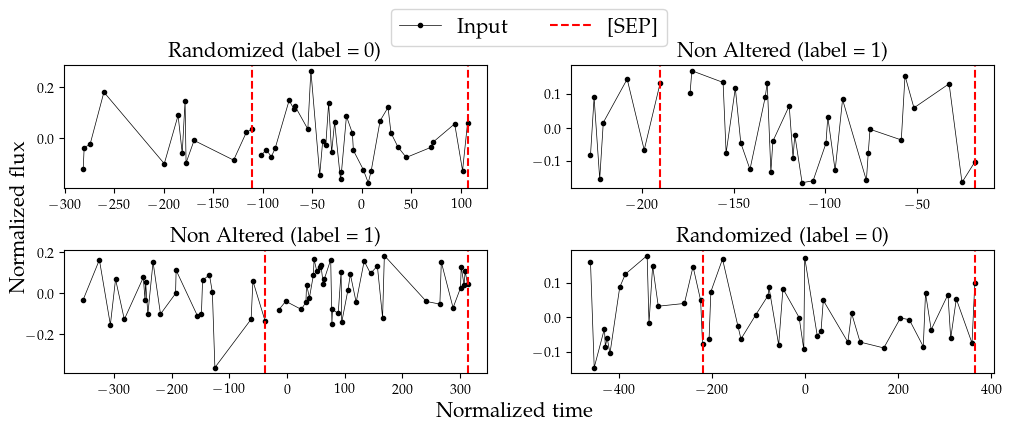

In [27]:
FS=15
ncols = 2
nrows = 2
fig, axes = plt.subplots(nrows,ncols, sharey=False, sharex=False,
                         figsize=(12,4),
                         gridspec_kw={'hspace': 0.5, 'wspace': 0.2})

axes = axes.flatten()

k = 0
k_pos = 0
k_neg = 0
for x, y in dataset.unbatch():       
    
    if y['nsp_label'] == 0:
        k_neg +=1
        if k_neg > nrows*ncols/2:
            continue
    else:
        k_pos +=1
        if k_pos > nrows*ncols/2:
            continue
        
        
    init = 1
    for index in tf.where(x['input'] == -98):
        partial = x['input'][init:index[0]]
        partial_times = x['times'][init:index[0]]
        partial_mask = x['mask_in'][init:index[0]]
        x_mask = tf.boolean_mask(partial ,partial_mask)
        t_mask = tf.boolean_mask(partial_times , partial_mask)

        axes[k].plot(t_mask, x_mask, color='k', linestyle='-', linewidth=.5, marker='.')
        axes[k].axvline(x = t_mask[-1], 
                        color = 'r', 
                        linestyle='--')
        init = index[0]
        
    if y['nsp_label'] == 0:
        axes[k].set_title('Randomized (label = 0)', fontsize=FS)
    else:
        axes[k].set_title('Non Altered (label = 1)', fontsize=FS)
        
    k+=1
    if k > nrows*ncols:
        break
        
axes[0].legend(['Input', '[SEP]'], ncol=2, 
               bbox_to_anchor = (1.45, 1.54), fontsize=FS)

fig.text(0.5, 0., 'Normalized time', ha='center', fontsize=FS)
fig.text(0.08, 0.5, 'Normalized flux', va='center', 
         rotation='vertical', fontsize=FS)
fig.savefig('./presentation/figures/rsp_input.pdf', 
            format='pdf', bbox_inches='tight')

In [13]:
from presentation.experiments.astromer_2.utils import load_clf_data
import pandas as pd
import os

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
class CONFIG:
    window_size=200
    nsp_prob=0.5
    nsp_fraction=0.5
    subdataset= 'atlas'
    fold=0
config = CONFIG()

DOWNSTREAM_DATA = os.path.join('./data/records', 
                               config.subdataset,
                               'fold_'+str(config.fold), 
                               config.subdataset+'_20')
num_cls = pd.read_csv(
        os.path.join(DOWNSTREAM_DATA, 'objects.csv')).shape[0]

loader = load_clf_data(config, batch_size=512, num_cls=num_cls, datapath=DOWNSTREAM_DATA)

[INFO] Repeating dataset x1 times
[INFO] Loading PT task: Masking
[INFO] Loading PT task: NSP
[INFO] Mov. win:  False
[INFO] Repeating dataset x1 times
[INFO] Loading PT task: Masking
[INFO] Loading PT task: NSP
[INFO] Mov. win:  False
[INFO] Repeating dataset x1 times
[INFO] Loading PT task: Masking
[INFO] Loading PT task: NSP
[INFO] Mov. win:  False


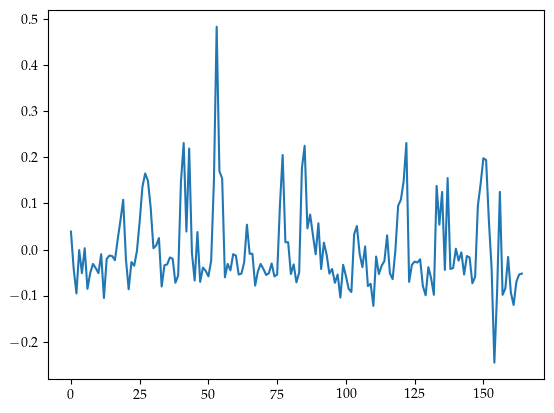

In [27]:
for x, y in loader['val'].unbatch():
    
    inp = tf.boolean_mask(x['input'], x['mask'])
    
    plt.plot(inp)
#     plt.plot(inp)
#     print(x['mask'])
#     print(x['input'])
    break